In [1]:
import beanmachine.ppl as bm
import beanmachine.ppl.experimental.vi.variational_infer
import numpy as np
import pandas as pd
import pplbench.models.n_schools
import seaborn as sns
import torch.distributions as dist
import torch
import xarray as xr
from torch import tensor

sns.set_style('darkgrid')

In [13]:
!pip list | grep widget

ipywidgets                        7.5.1
widgetsnbextension                3.5.1


## N-Schools Vectorized

In [2]:
seed = 42
train, test = pplbench.models.n_schools.NSchools.generate_data(seed)

In [16]:
dset = train

_u_sizes = [dset.num_districts_per_state * dset.num_states, dset.num_states, dset.num_types]
num_levels = len(_u_sizes)
torch_re_maps = []
for i in range(num_levels):
    re_map_i = torch.zeros((dset.n, _u_sizes[i]))
    for j in range(dset.n):
        if i == 0:
            # beta_district
            re_map_i[
                j,
                dset.state_idx[j] * dset.num_districts_per_state + dset.district_idx[j],
            ] = 1
        elif i == 1:
            # beta_state
            re_map_i[j, dset.state_idx[j]] = 1
        elif i == 2:
            # beta_type
            re_map_i[j, dset.type_idx[j]] = 1
        else:
            raise Exception("Should not occur.")
    torch_re_maps.append(re_map_i)


@bm.random_variable
def beta_baseline():
    return dist.StudentT(dset.dof_baseline, 0.0, dset.scale_baseline)

@bm.random_variable
def sigmas(i):
    assert i < num_levels
    return dist.HalfCauchy(
        [dset.scale_district, dset.scale_state, dset.scale_type][i]
    )

@bm.random_variable
def u(i):
    assert i < num_levels
    return dist.Independent(
        dist.Normal(torch.zeros(_u_sizes[i]), sigmas(i)),
        1,
    )

@bm.random_variable
def sigma_y():
    return dist.Independent(
        dist.Uniform(
            0.5*torch.ones(dset.n),
            1.5*torch.ones(dset.n),
        ),
        1,
    )

@bm.random_variable
def y():
    yhat = beta_baseline() + sum(
        torch.mm(torch_re_maps[i], u(i).reshape(_u_sizes[i], 1))
        for i in range(num_levels)
    )
    yhat = yhat.reshape(-1)
    return dist.Independent(
        dist.Normal(yhat, sigma_y()),
        1,
    )

In [82]:
queries = [beta_baseline()]
for i in range(num_levels):
    queries += [sigmas(i), u(i)]

observations = {
    y(): tensor(dset.Y.values).float(),
    sigma_y(): tensor(dset.sigma.values).float(),
}

vi_dicts = beanmachine.ppl.experimental.vi.variational_infer.MeanFieldVariationalInference().infer(
    queries,
    observations,
    num_iter=100,
)

/home/jovyan/work/flowtorch/flowtorch/params/dense_autoregressive.py:150: UserWarning: DenseAutoregressive input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [76]:
num_samples = 100

samples = pd.DataFrame()
beta_district = torch.zeros(num_samples, _u_sizes[1], _u_sizes[2])
samples["beta_baseline"] = vi_dicts(beta_baseline()).sample((num_samples,1)).squeeze()
for i, level in enumerate(["district", "state", "type"]):
    samples[f"sigma_{level}"] = vi_dicts(sigmas(i)).sample((num_samples,1)).squeeze()

    u_i = vi_dicts(u(i)).rsample((num_samples,))
    for j in range(_u_sizes[i]):
        if i == 0:
            # beta_district
            state = int(j / dset.num_districts_per_state)
            district = j % dset.num_districts_per_state
            beta_district[:, state, district] = u_i[
                :, j
            ]
        else:
            samples[f"beta_{level}"] = u_i[:, ]

res = xr.Dataset(
    {
        "sigma_state": (["draw"], samples["sigma_state"]),
        "sigma_district": (["draw"], samples["sigma_district"]),
        "sigma_type": (["draw"], samples["sigma_type"]),
        "beta_baseline": (["draw"], samples["beta_baseline"]),
        "beta_state": (["draw", "state"], tensor(samples["beta_state"]).numpy()),
        "beta_district": (
            ["draw", "state", "district"],
            beta_district.numpy(),
        ),
        "beta_type": (["draw", "type"], tensor(samples["beta_type"]).numpy()),
    },
    coords={
        "draw": np.arange(samples["beta_baseline"].shape[0]),
        "state": np.arange(dset.num_states),
        "district": np.arange(dset.num_districts_per_state),
        "type": np.arange(dset.num_types),
    },
)

<AxesSubplot:ylabel='Count'>

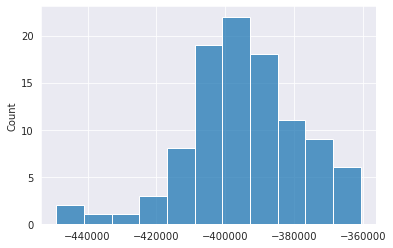

In [80]:
sns.histplot(pplbench.models.n_schools.NSchools.evaluate_posterior_predictive(res, test))

In [88]:
bm_samples = bm.CompositionalInference().infer(
    queries, 
    observations,
    num_samples=100,
    num_chains=1
)

## BMA++

In [39]:
import numpy as np
import pandas as pd

# N = 2000
# data = pd.DataFrame({
#     'dummy': np.random.randint(0, 4, size=N),
#     'yi': np.random.randn(N)+1.2,
#     'sei': np.random.randn(N)**2 / 10.,
# })

data = pd.read_csv('full_data_obfusc.csv', index_col=0)
data.head()

,io,co,ch,ii,yi,sei,aj
0,xmpx,eqvs,knuk,qeqc,0.002128,0.002872,ervt
1,xmpx,eqvs,nzck,taux,0.001371,0.002227,ervt
2,xmpx,eqvs,nzck,xiar,-0.000911,0.002166,ervt
3,xmpx,cpoq,jpqq,rvtx,0.005594,0.003061,ervt
4,xmpx,eqvs,knuk,mgel,-0.002489,0.003692,ervt


In [40]:
import beanmachine.ppl as bm
import torch.distributions as dist
import torch

fixed_effects = ['1']
#random_effects = [('dummy',)]
random_effects = [('co','ch','io')]

@bm.random_variable
def fe(i):
    return dist.Normal(torch.zeros(1), 2*torch.ones(1))

@bm.random_variable
def re_scale(re_name):
    return dist.HalfCauchy(torch.ones(1))

@bm.random_variable
def re(re_name, key):
    return dist.Normal(torch.zeros(1), re_scale(re_name))

@bm.random_variable
def prob_h():
    return dist.Beta(torch.ones(1), torch.ones(1))

@bm.random_variable
def h(i):
    return dist.Bernoulli(prob_h())

@bm.random_variable
def y(i):
    row = data.iloc[i]
    # TODO: support more than one random effect
    yhat = torch.zeros(1)
    if h(i) > 0.5:
        re_name = random_effects[0]
        key = tuple(row[x] for x in re_name)
        yhat = fe(0) + re(re_name, key)
    return dist.Normal(yhat, row["sei"]*torch.ones(1))
    
    
queries = [
    fe(0),
] + [
    re_scale(re) for re in random_effects
] + [
    re(re_name, re_key)
    for re_name in random_effects
    for re_key in data.apply(lambda row: tuple(row[x] for x in re_name), axis=1).unique()
] + [
    prob_h(),
] + [
    h(i) for i in range(data.shape[0])
]
observations = {
    y(i): torch.tensor(data.iloc[i]["yi"]) for i in range(data.shape[0])
}

In [41]:
import beanmachine.ppl.experimental.vi.variational_infer as vi
import plotly.graph_objects as go

fig = go.FigureWidget()
fig.add_scatter()
fig.data[0].y = []
fig.data[0].x = []
fig

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '0091b3c6-6e6c-4aa5-880e-a784f9292165', 'x': [], 'y': […

In [42]:
import time
start_time = time.time()

def on_iter(iter_num, loss):
    fig.data[0].y = list(fig.data[0].y) + [loss.float().item()]
    fig.data[0].x = list(fig.data[0].x) + [time.time() - start_time]

vi_approx = vi.MeanFieldVariationalInference().infer(queries, observations, num_iter=200, lr=1e-3, on_iter=on_iter)

/home/jovyan/work/flowtorch/flowtorch/params/dense_autoregressive.py:150: UserWarning:

DenseAutoregressive input_dim = 1. Consider using an affine transformation instead.



In [43]:
for rvid in queries:
    print(rvid, vi_approx(rvid).sample((1000,1)).float().mean())

fe(0,) tensor(-0.6074)
re_scale(('co', 'ch', 'io'),) tensor(0.6172)
re(('co', 'ch', 'io'), ('eqvs', 'knuk', 'xmpx')) tensor(0.6051)
re(('co', 'ch', 'io'), ('eqvs', 'nzck', 'xmpx')) tensor(0.6124)
re(('co', 'ch', 'io'), ('cpoq', 'jpqq', 'xmpx')) tensor(0.6258)
re(('co', 'ch', 'io'), ('eqvs', 'ytnw', 'gplm')) tensor(0.6181)
re(('co', 'ch', 'io'), ('eqvs', 'aoqm', 'gplm')) tensor(0.6102)
re(('co', 'ch', 'io'), ('eqvs', 'mnqe', 'gplm')) tensor(0.5959)
re(('co', 'ch', 'io'), ('eqvs', 'iqtq', 'eqxp')) tensor(0.6162)
re(('co', 'ch', 'io'), ('eqvs', 'fral', 'eqxp')) tensor(0.6095)
re(('co', 'ch', 'io'), ('eqvs', 'qjsp', 'knjl')) tensor(0.6095)
re(('co', 'ch', 'io'), ('eqvs', 'fral', 'bdfi')) tensor(0.6364)
re(('co', 'ch', 'io'), ('eqvs', 'qjsp', 'bdfi')) tensor(0.6183)
re(('co', 'ch', 'io'), ('eqvs', 'walj', 'jemi')) tensor(0.6255)
re(('co', 'ch', 'io'), ('eqvs', 'ytnw', 'jemi')) tensor(0.6116)
re(('co', 'ch', 'io'), ('howz', 'ovcg', 'yjzr')) tensor(0.6183)
re(('co', 'ch', 'io'), ('eqvs', 'kns

## Dev

In [1]:
import beanmachine.ppl as bm
import beanmachine.ppl.experimental.vi.variational_infer as vi
import torch
import torch.distributions as dist
from torch.distributions.constraint_registry import biject_to


x = bm.random_variable(lambda: dist.Beta(1.0, 1.0, validate_args=True))
vi_dicts = vi.MeanFieldVariationalInference().infer([x()], {}, num_iter=100)

/home/jovyan/work/flowtorch/flowtorch/params/dense_autoregressive.py:150: UserWarning: DenseAutoregressive input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [2]:
bij = biject_to(dist.Beta(1.0, 1.0).support)
bij(vi_dicts(x()).sample((1000,1))).mean()

tensor(0.5103)

## Test discrete enumeration

In [1]:
import beanmachine.ppl as bm
import beanmachine.ppl.experimental.vi.variational_infer as vi
import torch
import torch.distributions as dist
from torch.distributions.constraint_registry import biject_to

x = bm.random_variable(lambda: dist.Bernoulli(0.1, validate_args=True))
vi_dicts = vi.MeanFieldVariationalInference().infer([x()], {}, num_iter=1000)

dist.Categorical(logits=vi_dicts(x()).logits).probs

tensor([0.9000, 0.1000], grad_fn=<SoftmaxBackward>)

In [41]:
logits = torch.randn(4)
p = bm.random_variable(lambda: dist.Categorical(logits=logits))
print(dist.Categorical(logits=logits).probs)

vi_dicts = vi.MeanFieldVariationalInference().infer([p()], {}, num_iter=1000)
dist.Categorical(logits=vi_dicts(p()).logits).probs

tensor([0.6712, 0.1462, 0.1393, 0.0434])


tensor([0.6709, 0.1462, 0.1392, 0.0437], grad_fn=<SoftmaxBackward>)

In [5]:
dist.Bernoulli(0.5).enumerate_support().dtype

torch.float32

In [6]:
dist.Categorical(torch.randn(4)).enumerate_support().dtype

torch.int64

# SF vs enumeration

In [9]:
import torch.distributions.kl
import torch.autograd

p = dist.Bernoulli(0.5)
q = lambda prob: dist.Bernoulli(prob)

prob = torch.tensor(0.8, requires_grad=True)

torch.autograd.grad(
    torch.distributions.kl.kl_divergence(q(prob), p),
    prob)

(tensor(1.3863),)

Enumeration

In [10]:
torch.autograd.grad(
    prob*torch.log(prob/0.5) + (1-prob)*torch.log((1-prob)/0.5),
    prob)

(tensor(1.3863),)

SF estimator

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

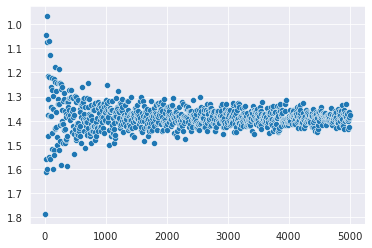

In [40]:
def f(N):
    z = q(prob).sample((N.int(),))
    return torch.autograd.grad(
        q(prob).log_prob(z),
        prob,
        grad_outputs=(q(prob).log_prob(z) - p.log_prob(z))/N,
        #grad_outputs=torch.ones(z.shape[0]) / N,
    )[0]

import seaborn as sns
sns.set_style("darkgrid")

Ns = torch.linspace(10, 5e3, steps=1000)
sns.scatterplot(
    Ns, [f(N) for N in Ns],
)